In [1]:
import numpy as np
import pandas as pd
import optimize_process
import pickle
import fit_model  # required for the pickled ode object
import scipy.integrate
import scipy.optimize
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.tri
import calc_rates
import copy
import color_scheme
import os
import collections

plt.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = (
    r"\usepackage{amsmath}" 
    + r"\usepackage{siunitx}" 
    + r"\usepackage{lmodern}" 
    + r"\input{" + f"{os.path.abspath('../data/00_abbrevs.tex')}" + r"}"
    + r"\sisetup{detect-all}"
    + r"\usepackage{sansmathfonts}"
)
np.random.seed(0)

plt.rcParams['savefig.dpi'] = 300
plt.rcParams["font.size"] = 14
fig_path = "../figs/"
data_path = "../data/"

use_AIC = False

In [2]:
# define constants and load model information

Y_XG = 0.627
Y_PG = 0.652
alpha = 0.2
points = 7
X0 = 30
V0 = 1.3
X_max = 60 # maximum biomass concentration is not reached when optimizing for P/X

with open("../data/odes.pickle", "rb") as f:
    odes = pickle.load(f)

ode_model = odes[alpha][points]


# the two functions are necessary for the pickled data (as default dicts were used)
def dict_list():
    return collections.defaultdict(list)


def dict_dict():
    return collections.defaultdict(dict)


with open("../data/odes_CV.pickle", "rb") as f:
    odes_CV = pickle.load(f)

with open(f"{data_path}spline_functions.pickle", "rb") as f:
    f_spline = pickle.load(f)

odes_CV = odes_CV[alpha][points]

with open(f"{data_path}ode_aic.pickle", "rb") as f:
    ode_aic = pickle.load(f)

if use_AIC:
    ode_model = ode_aic

f_ode = ode_model.f
f_g = ode_model.f_g
f_gm = ode_model.f_gm
f_gP = ode_model.f_gP


with open(f"{data_path}data_df.pickle", "rb") as f:
    data_df = pickle.load(f)

df_Vf = pd.read_csv(f"{data_path}volume_flow_rates.csv", index_col=0)
df_T = pd.read_csv(f"{data_path}temperatures.csv", index_col=0)

t_end = 12
V_end = 2 # maximum volume, will no be reached

In [3]:
with open("../data/f_base.pickle", "rb") as f:
    f_base = pickle.load(f)

k_f_base = f_base.slope
d_f_base = f_base.intercept
c_feed_gL = 390  # excluding base feed
density_glycerol = 1.261
density = 1 + c_feed_gL / 1000 * (1 - 1 / density_glycerol)
c_feed = c_feed_gL / density

def ode(x, u, x0):
    """
    model equation including expected base feed
    :param x: state variables X, P, G, V
    :param u: control variables f, T (c_feed is constant)
    :param x0: initial state variables
    """
    X = x[0]
    P = x[1]
    G = x[2]
    V = x[3]
    f = u[0]
    T = u[1]
    X0 = x0[0]
    V0 = x0[3]

    f_g = ode_model.f_g
    f_gm = ode_model.f_gm
    f_gP = ode_model.f_gP

    X = np.fmax(0, X)
    P = np.fmax(0, P)
    G = np.fmax(0, G)
    n = np.log(X * V / (X0 * V0)) / np.log(2)
    g = f_g(G, n, P, X, T)
    gm = f_gm(g, G, n, P, X, T)
    gP = f_gP(g, gm, G, n, P, X, T)
    g_mu = g - gm - gP
    mu = (g_mu * Y_XG + gP * Y_PG) * (1 - P / X)
    qP = (gP * Y_PG) * (1 - P / X)

    # include base feed in total feed
    f_real = f + X * V * (k_f_base * mu + d_f_base)
    c_feed_real = c_feed * f / f_real

    return [
        mu * X - f_real / V * X,
        qP * X - f_real / V * P,
        -g * (X - P) + f_real / V * (c_feed_real - G),
        f_real,
    ]

## Reference process
Instead of sampling the feed is increased to get the same concentrations and feed per biomass. The results will be transformed to a sampled process later

from here on we set $G$ = 0
The inclusion of $G$ in the ODE makes the equation stiff and hard to handle. As $G$ is practically zero, we can adapt the euqation that uptake is feed $g = f G_f / ((X-P) V)$ and $G = 0$.

In [4]:
def ode_no_G(x, u, x0, CV_process=None):
    """
    alternative version of the model equations
    assuming G=0 and the fed substrate is taken up immediately
    """
    X = x[0]
    P = x[1]
    V = x[2]
    f = u[0]
    c_f = u[1]
    T = u[2]
    X0 = x0[0]
    V0 = x0[2]

    if CV_process is None:
        f_gm = ode_model.f_gm
        f_gP = ode_model.f_gP
    else:
        f_gm = odes_CV[CV_process].f_gm
        f_gP = odes_CV[CV_process].f_gP

    n = np.log(X * V / (X0 * V0)) / np.log(2)
    g = f / V * c_f / (X - P)
    gm = f_gm(g, 0, n, P, X, T)
    gP = f_gP(g, gm, 0, n, P, X, T)
    g_mu = g - gm - gP
    mu = (g_mu * Y_XG + gP * Y_PG) * (1 - P / X)
    qP = (gP * Y_PG) * (1 - P / X)

    # include base feed in total feed
    f_real = f + X * V * (k_f_base * mu + d_f_base)

    return [mu * X - f_real / V * X, qP * X - f_real / V * P, f_real]

In [5]:
def add_sampling(df_in, sampling_volume=0.035, sampling_times=np.linspace(2, 10, 5)):
    """
    adds sampling to a process dataframe of an umsapled process, 35 mL every 2 h
    reduces the volume and the feed to the a equivalen process (same X and P)
    with sampling
    """
    df = df_in.copy()
    volumes = [df[df.index < ti].V.iloc[-1] for ti in sampling_times]
    def sampling_factor(t):
        sampling_factor = 1
        for Vi, ti in zip(volumes, sampling_times):
            if t < ti:
                break
            V_corr = Vi * sampling_factor
            sampling_factor *= 1 - sampling_volume / V_corr
        return sampling_factor

    df["sampling_factor"] = [sampling_factor(t) for t in df.index]
    df["V"] = df.V * df.sampling_factor
    df["f"] = df.f * df.sampling_factor
    return df


In [6]:
T0 = 304.15

x0 = np.array([X0, 0, 0, V0])

# as reference process a center point run of the training data is use
# the process with the closest X0 is


def f_substrate(t):
    return f_spline["DoE2_R4"].f_gly(t)


V_factor = V0 / f_spline["DoE2_R4"].V(0)


def get_ref_df(T_ref, ode, V_factor, f_substrate, V0, alpha=0.05, CV_process=None):
    V_factor = V0 / f_spline["DoE2_R4"].V(0)

    def f_ref(t, x, x0, V_factor, c_feed, T_ref):
        u = [f_substrate(t) * V_factor, c_feed, T_ref]
        return ode_no_G(x, u, x0)

    x0 = np.array([X0, 0, V0])
    ts = np.linspace(0, 12, 1000)
    res = scipy.integrate.solve_ivp(
        f_ref,
        [0, 12],
        x0,
        t_eval=ts,
        args=(x0, V_factor, c_feed, T_ref),
        dense_output=True,
    )
    f = np.array([f_substrate(t) for t in ts])
    df_ref = pd.DataFrame(res.y.T, columns=["X", "P", "V"], index=ts)
    df_ref["c_feed"] = c_feed
    df_ref["f"] = f * V_factor
    df_ref["n"] = np.log2(df_ref.X * df_ref.V / (df_ref.X.iloc[0] * V0))
    df_ref["T"] = T_ref

    return df_ref


df_ref = get_ref_df(304.15, ode_no_G, V_factor, f_substrate, V0)


# add_sampling(df_ref)

In [7]:
V0 = 1.3

class OptimizerWithSampling:
    """
    optimizes the simplified problem (feed is a linear function) including sampling
    uses differential evolution for optimization
    an i != 1 in the optimize method will use a piecewise linear feed function
    """
    def __init__(
        self,
        c_feed,
        t_end,
        X0,
        V0,
        f_ode,
        sampling_times=np.linspace(2, 12, 6),
        sampling_volumes=np.array([0.035] * 5 + [0]),
        # optimization bounds T, X0, V0
        bounds=[(305, 315), (20, 50), (0.5, 1.5)],
        CV_process=None,
    ) -> None:
        self.c_feed = c_feed
        self.t_end = t_end
        self.X0 = X0
        self.V0 = V0
        self.f_ode = f_ode
        self.sampling_times = sampling_times
        self.sampling_volumes = sampling_volumes
        self.bounds = bounds
        self.CV_process = CV_process

    def solve_ode_sampling(
        self,
        x0: np.ndarray,
        f,
        termination_events=[],
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        x_step = x0
        t_step = 0
        ts = list()
        ys = list()
        V0s = list()
        for sampling_time, sampling_volume in zip(
            self.sampling_times, self.sampling_volumes
        ):
            # print([x0])
            res = scipy.integrate.solve_ivp(
                fun=f,
                t_span=[t_step, sampling_time],
                y0=x_step,
                method="DOP853",
                rtol=1e-11,
                events=termination_events,
                args=[x0],
            )
            t_step = sampling_time
            x_step = [res.y[i][-1] for i in range(len(x0))]
            V0s.append(np.repeat(x0[-1], len(res.t)))
            # adapt V0 to calculate n correctly
            x0[-1] *= 1 - sampling_volume / x_step[-1]
            # adapt V for sampling
            x_step[-1] -= sampling_volume
            ts.append(res.t)
            ys.append(res.y)

            if len(res.t_events) == 0:
                pass
            elif len(res.t_events[0]) != 0:
                break

        t = np.hstack(ts)
        y = np.hstack(ys)
        V0 = np.hstack(V0s)
        return t, y, V0

    def f(self, x: np.ndarray):
        fis = x[:-1]
        T = x[-1]
        x0 = np.array([self.X0, 0, self.V0])

        def ode(t, x, x0):
            x = np.maximum(0, x)
            u = [self.get_f(t, fis), self.c_feed, T]
            return self.f_ode(x, u, x0, self.CV_process)

        t, x, V0 = self.solve_ode_sampling(x0, ode)
        return t, x, V0

    def f_opt(self, x):
        t, x, V0 = self.f(x)
        return -x[1][-1] / x[0][-1]

    def get_f(self, t, fis):
        f = fis[-1]
        tis = np.linspace(0, self.t_end, len(fis))
        for j in range(len(fis) - 1):
            if t <= tis[j + 1]:
                f = (fis[j] * (tis[j + 1] - t) + fis[j + 1] * (t - tis[j])) / (
                    tis[j + 1] - tis[j]
                )
                break
        return f

    def optimize(self, i, tol=1e-5):
        self.opt = scipy.optimize.differential_evolution(
            func=self.f_opt,
            bounds=[(0, 0.5)] * (i + 1) + self.bounds,
            tol=tol,
            # disp=True,
        )

        return self.opt

## Optimizing with arbitrary feed funtion
In practice this means the feed function is piecewice linear on 100 intervals. To solve this optimal control problem with orthogonal collocation a solver is written with casadi using IPopt.

In [8]:
# V_end = 2.0


def f_ode_opt(x, u, u_descrete, du, x0):
    return ode_no_G(x, [u[0], c_feed, u[1]], x0)


x_names = ["X", "P", "V"]
u_names = ["f", "T"]


def M(x, t_end):
    """cost function"""
    return -x[1] / x[0]

def M_P(x, t_end):
    """cost function"""
    return -x[1]


def u_guess(t):
    return [0.1, 305]


def du_guess(t):
    return [0, 0]


# def g_V_end(x):
#     V = x[2]
#     return V - V_end


model = optimize_process.Model(
    f=f_ode_opt,
    x0_min=[X0, 0, V0],
    x0_max=[X0, 0, V0],
    x_min=[1, 0, 0.5],
    x_max=[X_max, np.inf, np.inf],
    u_min=[0, 300],
    u_max=[np.inf, 310.0],
    # u_max=[0.06, 310.0],
    u0=[0, 300],
    u0_max=[np.inf, 310],
    # g_end=[g_V_end],
    # g_end_min=[0],
    # g_end_max=[0],
    M=M,
    N=100,
    p_order=1,
    x_names=x_names,
    u_names=u_names,
    u_guess=u_guess,
    du_guess=du_guess,
    t_min=10,
    t_max=12,
    collocation_polynom="legendre",
    du_penalty_factor=[1e-4, 1e0],
    solver_options={
        "ipopt.tol": 1e-13,
        "ipopt.constr_viol_tol": 1e-13,
        "ipopt.acceptable_constr_viol_tol": 1e-11,
        "ipopt.print_level": 3,
    },
    ode_solver_options={"method": "LSODA"},
)

model.solve()

df_T_opt = model.df
df = df_T_opt


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      803
                     variables with only lower bounds:      501
                variables with lower and upper bounds:      302
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 26

     

In [9]:
# t_end = 20

model.t_max = 20
model.t_min = 20
model.solve()
df_t_20 = model.df

# t_end = 30

model.t_max = 30
model.t_min = 30
model.solve()
df_t_30 = model.df

# t_end = 12
# T_max = 306.65

model.t_max = 12
model.t_min = 12
model.u_max[1] = 306.65
model.u0_max[1] = 306.65
model.solve()
df_T_335 = model.df

# T_max = 304.15

model.u_max[1] = 304.15
model.u0_max[1] = 304.15
model.solve()
df_T_31 = model.df

# opt P

model.M = M_P

# opt P 304.15 K
model.u_max[1] = 304.15
model.u0_max[1] = 304.15
model.solve()
df_T_31_P = model.df

# opt P 306.65.15 K

model.u_max[1] = 306.65
model.u0_max[1] = 306.65
model.solve()
df_T_335_P = model.df

# opt P T_opt

model.u_max[1] = 310
model.u0_max[1] = 310
model.solve()
df_T_opt_P = model.df

model.x0_min[0] = 1
model.x0_max[0] = X_max

# opt P 304.15 K
model.u_max[1] = 304.15
model.u0_max[1] = 304.15
model.solve()
df_T_31_P_X0 = model.df

# opt P 306.65.15 K

model.u_max[1] = 306.65
model.u0_max[1] = 306.65
model.solve()
df_T_335_P_X0  = model.df

# opt P T_opt

model.u_max[1] = 310
model.u0_max[1] = 310
model.solve()
df_T_opt_P_X0 = model.df


Total number of variables............................:      802
                     variables with only lower bounds:      501
                variables with lower and upper bounds:      301
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:  -2.0255140256900941e-01   -2.0255140256900941e-01
Dual infeasibility......:   3.5440785267981706e-16    3.5440785267981706e-16
Constraint violation....:   6.5656391495003599e-13    1.3145040611561853e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

We look at 3 different options
1. The effect of increase temperature form the center point to the (estimated) optimal temperature.
2. The predicted improvement for longer time intervals
3. optimizing P for maximal $X_\text{end}$ and free $X_0$. 

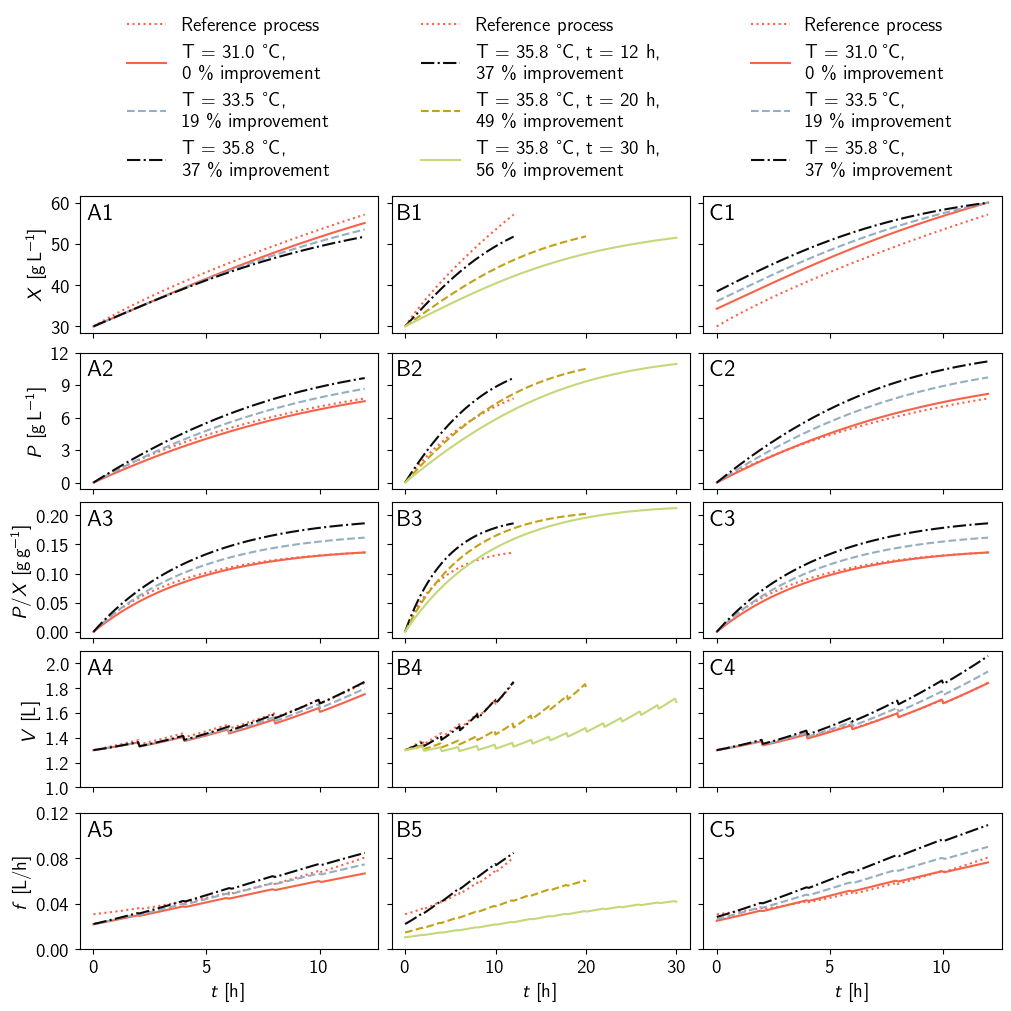

In [10]:
P_ref = df_ref.P.iloc[-1] / df_ref.X.iloc[-1]


def plot_opt_row(dfs, labels, P_ref, colors, styles, axs):

    for i, (df, c, ls, label) in enumerate(zip(dfs, colors, styles, labels)):
        improvement = (df.P.iloc[-1] / df.X.iloc[-1] / P_ref - 1) * 100
        if improvement != 0:
            label += f",\n {improvement:,.0f} \% improvement"
        axs[0].plot(
            df.X,
            c=c,
            ls=ls,
            label=label,
        )
        axs[1].plot(df.P, c=c, ls=ls)
        axs[2].plot(df.P / df.X, c=c, ls=ls)
        axs[3].plot(df.V, c=c, ls=ls)
        axs[4].plot(df.f[df.f.notna()], c=c, ls=ls)

    axs[0].set_ylabel(r"$X$ [\si{\gram\per\liter}]")
    axs[1].set_ylabel(r"$P$ [\si{\gram\per\liter}]")
    axs[2].set_ylabel(r"$P/X$ [\si{\gram\per\gram}]")
    axs[3].set_ylabel(r"$V$ [\si{\liter}]")
    axs[4].set_ylabel(r"$f$ [\si{\liter\per\hour]")




fig, axs_T = plt.subplots(
    5, 3, figsize=(10, 10), layout="constrained", sharex="col", sharey="row"
)
axs = axs_T.T
P_ref = df_ref.P.iloc[-1] / df_ref.X.iloc[-1]
plot_opt_row(
    [
        add_sampling(df_ref),
        add_sampling(df_T_31),
        add_sampling(df_T_335),
        add_sampling(df_T_opt),
    ],
    [
        "Reference process",
        "T = 31.0 \si{\celsius}",
        "T = 33.5 \si{\celsius}",
        "T = 35.8 \si{\celsius}",
    ],
    P_ref,
    list(color_scheme.processes[[0, 0, 3, 4]]),
    [":", "-", "--", "-."],
    axs[0],
)
plot_opt_row(
    [
        add_sampling(df_ref),
        add_sampling(df_T_opt),
        add_sampling(df_t_20, sampling_times=np.linspace(2, 20, 10)),
        add_sampling(df_t_30, sampling_times=np.linspace(2, 30, 15)),
    ],
    [
        "Reference process",
        "T = 35.8 \si{\celsius}, t = 12 \si{\hour}",
        "T = 35.8 \si{\celsius}, t = 20 \si{\hour}",
        "T = 35.8 \si{\celsius}, t = 30 \si{\hour}",
    ],
    P_ref,
    list(color_scheme.processes[[0, 4]]) + list(color_scheme.opt_longer_processes),
    [":", "-.", "--", "-"],
    axs[1],
)
plot_opt_row(
    [
        add_sampling(df_ref),
        add_sampling(df_T_31_P_X0),
        add_sampling(df_T_335_P_X0),
        add_sampling(df_T_opt_P_X0),
    ],
    [
        "Reference process",
        "T = \qty{31.0}{\celsius}",
        "T = \qty{33.5}{\celsius}",
        "T = \qty{35.8}{\celsius}",
    ],
    P_ref,
    list(color_scheme.processes[[0, 0, 3, 4]]),
    [":", "-", "--", "-."],
    axs[2],
)
# ax1.set_ylim(0, 9)

[ax.set_xlabel("$t$ [\si{\hour}]") for ax in axs[:, -1]]


for i in range(5):
    for name, ax in zip([f"{x}{i+1}" for x in ["A", "B", "C"]], axs[:, i]):
        trans = matplotlib.transforms.ScaledTranslation(
            5 / 72, -5 / 72, fig.dpi_scale_trans
        )
        ax.text(
            0.0,
            1.0,
            name,
            transform=ax.transAxes + trans,
            fontsize="large",
            verticalalignment="top",
            fontfamily="sans",
            bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
        )

[
    ax.legend(
        ncol=1,
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        frameon=False,
    )
    for ax in [axs[i, 0] for i in range(3)]
]

[ax.set_ylabel(None) for ax in np.hstack((axs[1], axs[2]))]

axs[0, 0].set_yticks(range(30, 70, 10))
axs[0, 1].set_yticks(range(0, 14, 3))
axs[0, 2].set_yticks(np.linspace(0, 0.2, 5))
axs[0, 3].set_yticks(np.linspace(1, 2, 6))
axs[0, 4].set_yticks(np.linspace(0, 0.12, 4))

plt.savefig(f"{fig_path}optima.png")
plt.show()

In [11]:
T = df["T"].iloc[0]

f_opt = scipy.interpolate.UnivariateSpline(
    df.index[df.f.notna()], df.f[df.f.notna()], k=1, s=0, ext=3
)

# print(f_opt(0))

x0 = np.array([df.X.iloc[0], 0, df.V.iloc[0]])


def f(t, x):
    u = np.array([f_opt(t), c_feed, T])
    return ode_no_G(x, u, x0)


sol = scipy.integrate.solve_ivp(
    fun=f, t_span=[0, t_end], y0=x0, method="DOP853", rtol=1e-11, dense_output=True
)

ts = np.linspace(0, t_end, t_end * 10 + 1)
df_opt = pd.DataFrame(sol.sol(ts).T, columns=["X", "P", "V"], index=ts)
df_opt["f"] = f_opt(ts)

df_opt["n"] = np.log2(df_opt.X * df_opt.V / (df_opt.X.iloc[0] * df_opt.V.iloc[0]))
# print(df_opt)
V_sampling = 0.05


def get_V_end(V0):
    df = df_opt.copy()
    df["V"] = df.V * V0 / df.V.iloc[0]
    df["f"] = df.f * V0 / df.V.iloc[0]
    for t in np.linspace(2, 10, 5):
        V0 = df.V[t]
        V1 = V0 - V_sampling
        sampling_factor = V1 / V0
        df.V[df_opt.index > t] = df.V * sampling_factor
        df.f[df_opt.index > t] = df.f * sampling_factor
    return df.V.iloc[-1] - 2


res = scipy.optimize.root(get_V_end, 1)
V0_opt = res.x[0]
V0_old = df_opt.V.iloc[0]
# print(V0_opt)
# print(df_opt)
df_opt["V"] = df_opt.V * V0_opt / V0_old
df_opt["f"] = df_opt.f * V0_opt / V0_old
# print(df_opt)

for t in np.linspace(2, 10, 5):
    V_0 = df_opt.V[t]
    V_1 = V_0 - V_sampling
    sampling_factor = V_1 / V_0
    df_opt.V[df_opt.index > t] = df_opt.V * sampling_factor
    df_opt.f[df_opt.index > t] = df_opt.f * sampling_factor

df_opt["c_feed"] = c_feed
df_opt["T"] = T

In [12]:
opt_T_opt = OptimizerWithSampling(
    c_feed,
    t_end,
    X0,
    V0,
    ode_no_G,
    bounds=[(300, 315)],
)
opt_T_opt.optimize(1, tol=1e-5)
opt_T_opt.opt

     fun: -0.18635595812001823
     jac: array([-7.50788320e-06, -1.69309011e-07,  2.22044429e-07])
 message: 'Optimization terminated successfully.'
    nfev: 1210
     nit: 25
 success: True
       x: array([2.15397000e-02, 8.46860529e-02, 3.08935631e+02])

In [13]:
0.186988079897308 / 0.18709401244766544

0.999433800424869

In [14]:
opt31 = OptimizerWithSampling(
    c_feed,
    t_end,
    X0,
    V0,
    ode_no_G,
    bounds=[(304.15, 304.15)],
)
opt31.optimize(1)
opt31.opt

/home/users/gschloegel/.conda/envs/rpy/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:1458: RuntimeWarning: invalid value encountered in divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


     fun: -0.13641428675136746
     jac: array([-1.02612363e-05,  8.52651283e-05,             nan])
 message: 'Optimization terminated successfully.'
    nfev: 867
     nit: 18
 success: True
       x: array([2.20836587e-02, 6.73007731e-02, 3.04150000e+02])

In [15]:
opt335 = OptimizerWithSampling(
    c_feed,
    t_end,
    X0,
    V0,
    ode_no_G,
    bounds=[(306.65, 306.65)],
)
opt335.optimize(1)
opt335.opt

     fun: -0.16176484791959678
     jac: array([ 6.69464484e-06, -4.58189043e-05,             nan])
 message: 'Optimization terminated successfully.'
    nfev: 1002
     nit: 21
 success: True
       x: array([2.19043030e-02, 7.51141017e-02, 3.06650000e+02])

In [16]:
opt36 = OptimizerWithSampling(
    c_feed,
    t_end,
    X0,
    V0,
    ode_no_G,
    bounds=[(309.15, 309.15)],
)
opt36.optimize(1)
opt36.opt

     fun: -0.18369988352411834
     jac: array([-6.47537579e-06,  6.32494057e-05,             nan])
 message: 'Optimization terminated successfully.'
    nfev: 867
     nit: 18
 success: True
       x: array([2.15843107e-02, 8.35574522e-02, 3.09150000e+02])

In [17]:
opt_T_opt.opt

     fun: -0.18635595812001823
     jac: array([-7.50788320e-06, -1.69309011e-07,  2.22044429e-07])
 message: 'Optimization terminated successfully.'
    nfev: 1210
     nit: 25
 success: True
       x: array([2.15397000e-02, 8.46860529e-02, 3.08935631e+02])

In [18]:
PX_ref = df_ref.P.iloc[-1] / df_ref.X.iloc[-1]
- opt_T_opt.opt.fun / PX_ref, - opt36.opt.fun / PX_ref

(1.370774274952091, 1.3512370475666993)

In [19]:
df_ref335 = get_ref_df(33.5 + 273.15, ode_no_G, V_factor, f_substrate, V0)
df_ref36 = get_ref_df(36 + 273.15, ode_no_G, V_factor, f_substrate, V0)

In [20]:
df_ref_CV = get_ref_df(
    304.15, ode_no_G, CV_process="DoE2_R2", V_factor=V_factor, f_substrate=f_substrate, V0=V0
)

In [21]:
X_max_ref = df_ref.X.max()
P_max_ref = df_ref.P.max()
V_max_ref = df_ref.V.max()
f_max_ref = df_ref.f.max()
df_ref["g"] = df_ref.f / df_ref.V * df_ref.c_feed / (df_ref.X - df_ref.P)
df_ref["gm"] = f_gm(df_ref.g, 0, df_ref.n, df_ref.P, df_ref.X, T)
df_ref["gP"] = f_gP(df_ref.g, df_ref.gm, 0, df_ref.n, df_ref.P, df_ref.X, T)
df_ref["qP"] = df_ref.gP * Y_PG * (1 - df_ref.P / df_ref.X)
df_ref["g_mu"] = df_ref.g - df_ref.gm - df_ref.gP
df_ref["mu"] = (df_ref.g_mu * Y_XG + df_ref.gP * Y_PG) * (1 - df_ref.P / df_ref.X)
mu_mean_ref = df_ref.mu.mean()

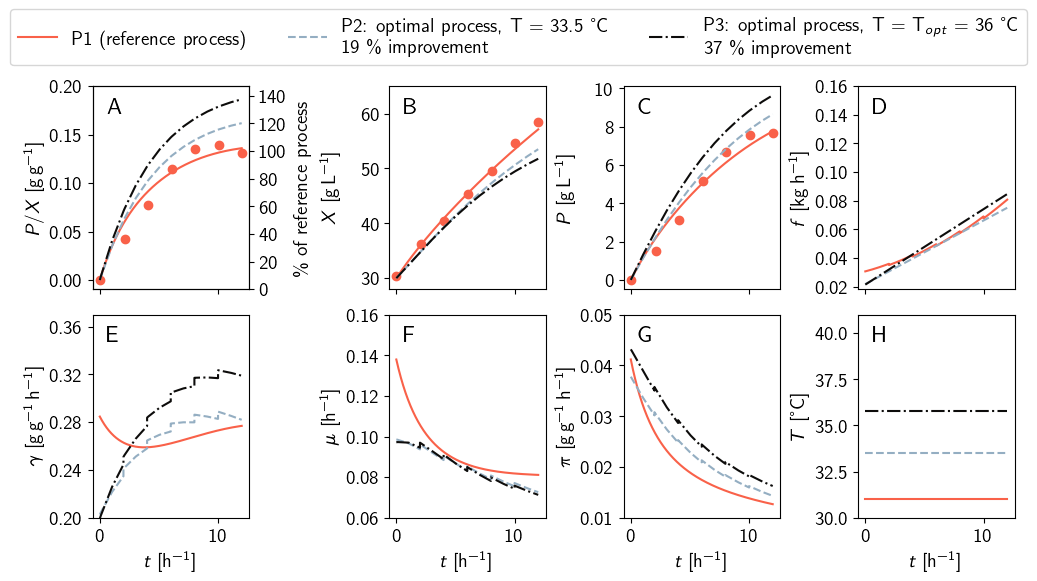

In [22]:
data_df_opt = data_df[data_df.process == "DoE2_R4"]


def plot_opt_sampling_qS(
    optima: list,
    labels: list[str],
    styles=["-", "--", "-.", ":", ":"],
    colors=["b", "orange", "g", "r", "m"],
    filename=None,
    legend_rows=1,
    return_fig=False,
):
    (fig, [[ax_PX, ax_X, ax_P, ax_f], [ax_qG, ax_mu, ax_qP, ax_T]]) = plt.subplots(
        2,
        4,
        figsize=(10, 5),
        layout="constrained",
        sharex=True,
    )

    for opt, label, style, color in zip(optima, labels, styles, colors):
        if isinstance(opt, pd.DataFrame):
            df = opt
            c_f = df.c_feed
            T = df["T"]
        else:
            t, x, V0 = opt.f(opt.opt.x)
            c_f = opt.c_feed
            fis = opt.opt.x[:-1]
            f = [opt.get_f(ti, fis) for ti in t]
            T = opt.opt.x[-1]
            df = pd.DataFrame(x.T, columns=["X", "P", "V"], index=t)
            X0 = df.X.iloc[0]
            df["f"] = f
            df["n"] = np.log2(df.X * df.V / (X0 * V0))

        df["f_X"] = df.f * c_f / (df.X * df.V)
        df["g"] = df.f / df.V * c_f / (df.X - df.P)
        df["gm"] = f_gm(df.g, 0, df.n, df.P, df.X, T)
        df["gP"] = f_gP(df.g, df.gm, 0, df.n, df.P, df.X, T)
        df["qP"] = df.gP * Y_PG * (1 - df.P / df.X)
        df["g_mu"] = df.g - df.gm - df.gP
        df["mu"] = (df.g_mu * Y_XG + df.gP * Y_PG) * (1 - df.P / df.X)
        df["qG"] = df.f / df.V * c_f / (df.X)

        df.X.plot(ax=ax_X, label=label, linestyle=style, color=color)
        ax_P.plot(df.P, linestyle=style, color=color)
        # ax2.plot(df.V, linestyle=style, color=color)
        ax_f.plot(df.f, linestyle=style, color=color)
        ax_PX.plot(df.P / df.X, linestyle=style, color=color)
        ax_mu.plot(df.mu, linestyle=style, color=color)
        ax_qG.plot(df.qG, linestyle=style, color=color)
        ax_T.plot(df.index, np.ones(len(df.index)) * (T - 273.15), linestyle=style, color=color)
        ax_qP.plot(df.qP, linestyle=style, color=color)

    ax_X.scatter(
        data_df_opt.t,
        data_df_opt.X,
        color=colors[0],
        # label="experimental data,\nreference process",
    )
    ax_P.scatter(data_df_opt.t, data_df_opt.P, color=colors[0])
    # ax2.scatter(data_df_opt.t, data_df_opt.V, color=colors[0])
    # ax3.scatter(data_df_opt.t, f_spline["DoE2_R4"].f_gly(data_df_opt.t), color=colors[0])
    ax_PX.scatter(data_df_opt.t, data_df_opt.P / data_df_opt.X, color=colors[0])

    ax_X.set_ylabel(r"$X$ [\si{\gram\per\liter}]")
    ax_P.set_ylabel(r"$P$ [\si{\gram\per\liter}]")
    # ax2.set_ylabel("Volume [g L$^{-1}$]")
    ax_f.set_ylabel(r"$f$ [\si{\kilogram\per\hour}]")
    ax_PX.set_ylabel(r"$P/X$ [\si{\gram\per\gram}]")
    ax_mu.set_ylabel(r"$\mu$ [\si{\per\hour}]")
    ax_qG.set_ylabel(r"$\qG$ [\si{\gram\per\gram\per\hour}]")
    [ax.set_xlabel(r"$t$ [\si{\per\hour}]") for ax in [ax_qG, ax_mu, ax_qP, ax_T]]
    ax_qP.set_ylabel(r"$\qP$ [\si{\gram\per\gram\per\hour}]")
    ax_T.set_ylabel(r"$T$ [\si{\celsius}]")
    legend = fig.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=5,
    )

    ax_T.set_ylim(None, 37)

    ax_PX.set_yticks(np.linspace(0, 0.2, 5))
    ax_X.set_yticks(np.linspace(30, 60, 4))
    ax_P.set_yticks(np.linspace(0, 10, 6))
    ax_f.set_yticks(np.linspace(0.02, 0.16, 8))
    ax_qG.set_yticks(np.linspace(0.2, 0.36, 5))
    ax_mu.set_yticks(np.linspace(0.06, 0.16, 6))
    ax_qP.set_yticks(np.linspace(0.01, 0.05, 5))

    ax_X.set_ylim(28, 65)
    ax_T.set_ylim(30, 41)
    ax_qG.set_ylim(0.2, 0.37)


    # ax_X_T = ax_X.twinx()
    # mn, mx = ax_X.get_ylim()
    # ax_X_T.set_ylim(mn * 100 / X_max_ref, mx * 100 / X_max_ref)
    # ax_X_T.set_ylabel(r"\% of reference process")

    # ax_P_T = ax_P.twinx()
    # mn, mx = ax_P.get_ylim()
    # ax_P_T.set_ylim(mn * 100 / P_max_ref, mx * 100 / P_max_ref)
    # ax_P_T.set_ylabel(r"\% of reference process")

    ax_PX_T = ax_PX.twinx()
    mn, mx = ax_PX.get_ylim()
    ax_PX_T.set_ylim(mn * 100 / P_max_ref / X_max_ref, mx * 100 / (P_max_ref / X_max_ref))
    ax_PX_T.set_ylabel(r"\% of reference process")

    ax_PX_T.set_yticks(np.linspace(0, 140, 8))


    # ax_f_T = ax_f.twinx()
    # mn, mx = ax_f.get_ylim()
    # ax_f_T.set_ylim(mn * 100 / f_max_ref, mx * 100 / f_max_ref)
    # ax_f_T.set_ylabel(r"\% of reference process")

    # ax2T = ax2.twinx()
    # mn, mx = ax2.get_ylim()
    # ax2T.set_ylim(
    #     mn * 100 / (P_max_ref / X_max_ref), mx * 100 / (P_max_ref / X_max_ref)
    # )
    # ax2T.set_ylabel(r"% of reference process")

    # ax_mu_T = ax_mu.twinx()
    # mn, mx = ax_mu.get_ylim()
    # ax_mu_T.set_ylim(mn * 100 / mu_mean_ref, mx * 100 / mu_mean_ref)
    # ax_mu_T.set_ylabel(r"% of reference process mean")

    for name, ax in zip(
        ["A", "B", "C", "D", "E", "F", "G", "H"],
        [ax_PX, ax_X, ax_P, ax_f, ax_qG, ax_mu, ax_qP, ax_T],
    ):
        trans = matplotlib.transforms.ScaledTranslation(
            5 / 72, -5 / 72, fig.dpi_scale_trans
        )
        ax.text(
            0.05,
            0.98,
            name,
            transform=ax.transAxes + trans,
            fontsize="large",
            verticalalignment="top",
            fontfamily="sans",
            bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
        )

    # fig.delaxes(ax5)

    fig.align_labels()

    if filename is not None:
        fig.savefig(filename, bbox_inches="tight")


    plt.show()

    if return_fig:
        return fig, [[ax_PX, ax_X, ax_P, ax_f], [ax_qG, ax_mu, ax_qP, ax_T]]


P2_improvement = -opt335.opt.fun / (df_ref.P.iloc[-1] / df_ref.X.iloc[-1]) * 100 - 100
P3_improvement = (
    -opt_T_opt.opt.fun / (df_ref.P.iloc[-1] / df_ref.X.iloc[-1]) * 100 - 100
)

plot_opt_sampling_qS(
    [
        add_sampling(df_ref),
        # opt31,
        opt335,
        opt_T_opt,
    ],
    [
        "P1 (reference process)",
        # "P1: optimal process, T = 31.0 °C\n11 % improvement",
        f"P2: optimal process, T = 33.5 °C\n{P2_improvement:.0f} \% improvement",
        "P3: optimal process, T = T$_{opt}$ = 36 °C\n"
        + f"{P3_improvement:.0f} \% improvement ",
        # "P1",
        # "P2",
        # "P3",
    ],
    # filename=f"{fig_path}suggested_processes_qS.png",
    styles=["-", "--", "-."],
    colors=color_scheme.processes[[0, 3, 4]],
)

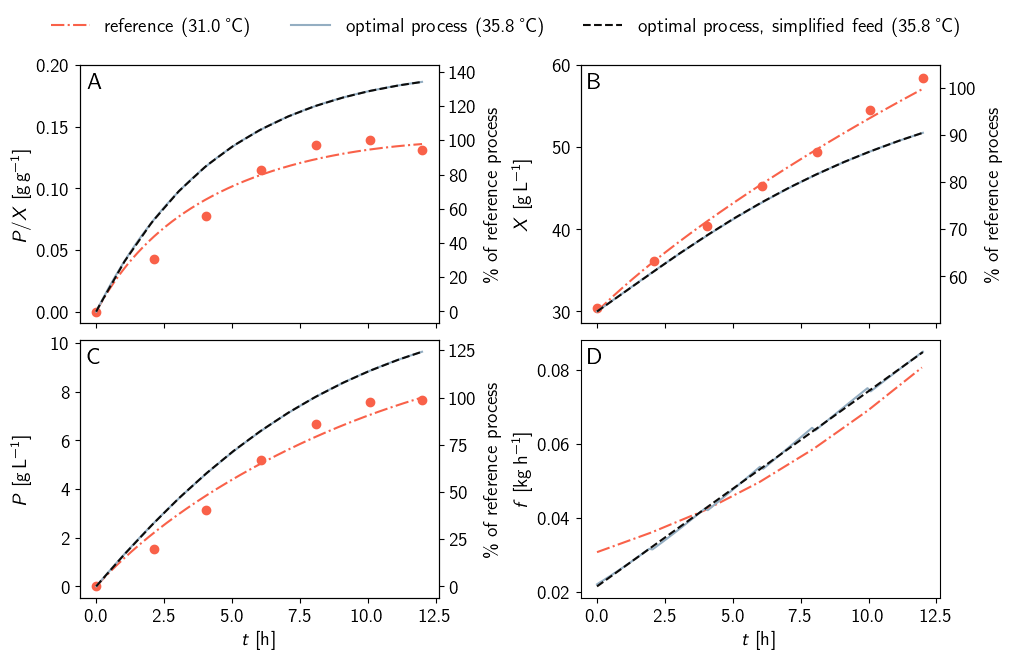

In [23]:
data_df_opt = data_df[data_df.process == "DoE2_R4"]


def plot_opt_sampling(
    optima: list,
    labels: list[str],
    styles=["-", "--", "-.", ":", ":"],
    colors=["b", "orange", "g", "r", "m"],
    filename=None,
    legend_rows=1,
    return_fig=False,
    single_row=False,
    data_df_opt=data_df_opt,
    
):
    if single_row:
        fig, [ax_PX, ax_X, ax_P, ax_f] = plt.subplots(
            1,
            4,
            figsize=(12, 3.5),
            layout="constrained",
            sharex=True,
        )
    else:
        fig, [(ax_PX, ax_X), (ax_P, ax_f)] = plt.subplots(
            2,
            2,
            figsize=(10, 6),
            layout="constrained",
            sharex=True,
        )

    for opt, label, style, color in zip(optima, labels, styles, colors):
        if isinstance(opt, pd.DataFrame):
            df = opt
            # c_f = df.c_feed
            T = df["T"]
        else:
            t, x, V0 = opt.f(opt.opt.x)
            # c_f = opt.c_feed
            fis = opt.opt.x[:-1]
            f = [opt.get_f(ti, fis) for ti in t]
            T = opt.opt.x[-1]
            df = pd.DataFrame(x.T, columns=["X", "P", "V"], index=t)
            X0 = df.X.iloc[0]
            df["f"] = f
            df["n"] = np.log2(df.X * df.V / (X0 * V0))

        # df["f_X"] = df.f * c_f / (df.X * df.V)
        # df["g"] = df.f / df.V * c_f / (df.X - df.P)
        # df["gm"] = f_gm(df.g, 0, df.n, df.P, df.X, T)
        # df["gP"] = f_gP(df.g, df.gm, 0, df.n, df.P, df.X, T)
        # df["qP"] = df.gP * Y_PG * (1 - df.P / df.X)
        # df["g_mu"] = df.g - df.gm - df.gP
        # df["mu"] = (df.g_mu * Y_XG + df.gP * Y_PG) * (1 - df.P / df.X)
        # df["qG"] = df.f / df.V * c_f / (df.X)

        df.X.plot(ax=ax_X, label=label, linestyle=style, color=color)
        ax_P.plot(df.P, linestyle=style, color=color)
        ax_f.plot(df[df.f.notna()].f, linestyle=style, color=color)
        ax_PX.plot(df.P / df.X, linestyle=style, color=color)

    if data_df_opt is not None:
        ax_X.scatter(
            data_df_opt.t,
            data_df_opt.X,
            color=colors[0],
            # label="experimental data,\nreference process",
        )
        ax_P.scatter(data_df_opt.t, data_df_opt.P, color=colors[0])
        # ax2.scatter(data_df_opt.t, data_df_opt.V, color=colors[0])
        # ax3.scatter(data_df_opt.t, f_spline["DoE2_R4"].f_gly(data_df_opt.t), color=colors[0])
        ax_PX.scatter(data_df_opt.t, data_df_opt.P / data_df_opt.X, color=colors[0])

    ax_X.set_ylabel(r"$X$ [\si{\gram\per\liter}]")
    ax_P.set_ylabel(r"$P$ [\si{\gram\per\liter}]")
    # ax2.set_ylabel("Volume [g L$^{-1}$]")
    ax_f.set_ylabel(r"$f$ [\si{\kilogram\per\hour}]")
    ax_PX.set_ylabel(r"$P/X$ [\si{\gram\per\gram}]")

    ax_PX_T = ax_PX.twinx()
    mn, mx = ax_PX.get_ylim()
    ax_PX_T.set_ylim(
        mn * 100 / (P_max_ref / X_max_ref), mx * 100 / (P_max_ref / X_max_ref)
    )
    ax_PX_T.set_ylabel(r"\unit{\percent} of reference process")

    ax_PX_T.set_yticks(np.linspace(0, 140, 8))

    ax_P_T = ax_P.twinx()
    mn, mx = ax_P.get_ylim()
    ax_P_T.set_ylim(mn * 100 / P_max_ref, mx * 100 / P_max_ref)
    ax_P_T.set_ylabel(r"\unit{\percent} of reference process")

    ax_X_T = ax_X.twinx()
    mn, mx = ax_X.get_ylim()
    ax_X_T.set_ylim(mn * 100 / X_max_ref, mx * 100 / X_max_ref)
    ax_X_T.set_ylabel(r"\unit{\percent} of reference process")

    legend = fig.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=5,
        frameon=False,
    )

    ax_PX.set_yticks(np.linspace(0, 0.2, 5))
    ax_X.set_yticks(np.linspace(30, 60, 4))
    ax_P.set_yticks(np.linspace(0, 10, 6))
    # ax_f.set_yticks(np.linspace(0.02, 0.16, 8))

    # ax_X.set_ylim(28, 65)
    if single_row:
        [ax.set_xlabel(r"$t$ [\unit{\hour}]") for ax in (ax_PX, ax_X, ax_P, ax_f)]
    else:
        [ax.set_xlabel(r"$t$ [\unit{\hour}]") for ax in (ax_P, ax_f)]

        for name, ax in zip(
            ["A", "B", "C", "D", "E", "F", "G", "H"],
            [ax_PX, ax_X, ax_P, ax_f],
        ):
            trans = matplotlib.transforms.ScaledTranslation(
                5 / 72, -5 / 72, fig.dpi_scale_trans
            )
            ax.text(
                0.0,
                1.0,
                name,
                transform=ax.transAxes + trans,
                fontsize="large",
                verticalalignment="top",
                fontfamily="sans",
                bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
            )

    # fig.delaxes(ax5)

    fig.align_labels()

    if filename is not None:
        fig.savefig(filename, bbox_inches="tight")

    plt.show()

    if return_fig:
        return fig, [[ax_PX, ax_X, ax_P, ax_f], [ax_qG, ax_mu, ax_qP, ax_T]]


P2_improvement = -opt335.opt.fun / (df_ref.P.iloc[-1] / df_ref.X.iloc[-1]) * 100 - 100
P3_improvement = (
    -opt_T_opt.opt.fun / (df_ref.P.iloc[-1] / df_ref.X.iloc[-1]) * 100 - 100
)

df = add_sampling(df_ref).copy()

for i in range(len(df.index)):
    if i not in [len(df.index) // 6 * i for i in range(7)]:
        df.iloc[i, 4] = np.nan

plot_opt_sampling(
    [
        # add_sampling(df_ref),
        df,
        add_sampling(df_T_opt),
        opt_T_opt,
    ],
    [
        r"reference (\qty{31.0}{\celsius})",
        r"optimal process (\qty{35.8}{\celsius})",
        r"optimal process, simplified feed (\qty{35.8}{\celsius})",
        # "P1",
        # "P2",
        # "P3",
    ],
    filename=f"{fig_path}optima_short.png",
    styles=["-.", "-", "--"],
    colors=color_scheme.processes[[0, 3, 4]],
    # colors=[color_scheme.processes[0], color_scheme.opt_longer_processes[0], color_scheme.processes[4]],
)

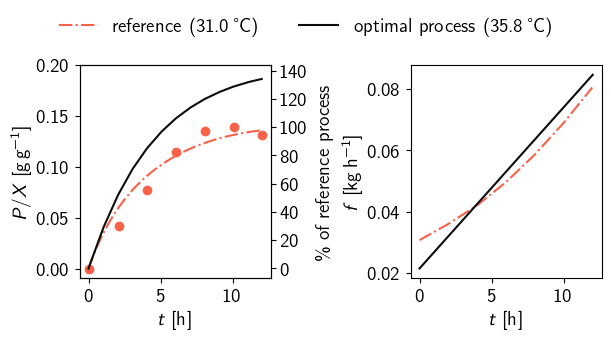

In [24]:
data_df_opt = data_df[data_df.process == "DoE2_R4"]


def plot_opt_sampling_2_plots(
    optima: list,
    labels: list[str],
    styles=["-", "--", "-.", ":", ":"],
    colors=["b", "orange", "g", "r", "m"],
    filename=None,
    legend_rows=1,
    return_fig=False,
    
):

    fig, [ax_PX, ax_f] = plt.subplots(
        1,
        2,
        figsize=(6, 2.8),
        layout="constrained",
        sharex=True,
    )

    for opt, label, style, color in zip(optima, labels, styles, colors):
        if isinstance(opt, pd.DataFrame):
            df = opt
            # c_f = df.c_feed
            T = df["T"]
        else:
            t, x, V0 = opt.f(opt.opt.x)
            # c_f = opt.c_feed
            fis = opt.opt.x[:-1]
            f = [opt.get_f(ti, fis) for ti in t]
            T = opt.opt.x[-1]
            df = pd.DataFrame(x.T, columns=["X", "P", "V"], index=t)
            X0 = df.X.iloc[0]
            df["f"] = f
            df["n"] = np.log2(df.X * df.V / (X0 * V0))

        # df["f_X"] = df.f * c_f / (df.X * df.V)
        # df["g"] = df.f / df.V * c_f / (df.X - df.P)
        # df["gm"] = f_gm(df.g, 0, df.n, df.P, df.X, T)
        # df["gP"] = f_gP(df.g, df.gm, 0, df.n, df.P, df.X, T)
        # df["qP"] = df.gP * Y_PG * (1 - df.P / df.X)
        # df["g_mu"] = df.g - df.gm - df.gP
        # df["mu"] = (df.g_mu * Y_XG + df.gP * Y_PG) * (1 - df.P / df.X)
        # df["qG"] = df.f / df.V * c_f / (df.X)

        # df.X.plot(ax=ax_X, label=label, linestyle=style, color=color)
        # ax_P.plot(df.P, linestyle=style, color=color)
        ax_f.plot(df[df.f.notna()].f, linestyle=style, color=color)
        ax_PX.plot(df.P / df.X, linestyle=style, color=color, label=label)

    # ax_X.scatter(
    #     data_df_opt.t,
    #     data_df_opt.X,
    #     color=colors[0],
    #     # label="experimental data,\nreference process",
    # )
    # ax_P.scatter(data_df_opt.t, data_df_opt.P, color=colors[0])
    # ax2.scatter(data_df_opt.t, data_df_opt.V, color=colors[0])
    # ax3.scatter(data_df_opt.t, f_spline["DoE2_R4"].f_gly(data_df_opt.t), color=colors[0])
    ax_PX.scatter(data_df_opt.t, data_df_opt.P / data_df_opt.X, color=colors[0])

    # ax_X.set_ylabel(r"$X$ [\si{\gram\per\liter}]")
    # ax_P.set_ylabel(r"$P$ [\si{\gram\per\liter}]")
    # ax2.set_ylabel("Volume [g L$^{-1}$]")
    ax_f.set_ylabel(r"$f$ [\si{\kilogram\per\hour}]")
    ax_PX.set_ylabel(r"$P/X$ [\si{\gram\per\gram}]")

    ax_PX_T = ax_PX.twinx()
    mn, mx = ax_PX.get_ylim()
    ax_PX_T.set_ylim(
        mn * 100 / (P_max_ref / X_max_ref), mx * 100 / (P_max_ref / X_max_ref)
    )
    ax_PX_T.set_ylabel(r"\unit{\percent} of reference process")

    ax_PX_T.set_yticks(np.linspace(0, 140, 8))

    # ax_P_T = ax_P.twinx()
    # mn, mx = ax_P.get_ylim()
    # ax_P_T.set_ylim(mn * 100 / P_max_ref, mx * 100 / P_max_ref)
    # ax_P_T.set_ylabel(r"\unit{\percent} of reference process")

    # ax_X_T = ax_X.twinx()
    # mn, mx = ax_X.get_ylim()
    # ax_X_T.set_ylim(mn * 100 / X_max_ref, mx * 100 / X_max_ref)
    # ax_X_T.set_ylabel(r"\unit{\percent} of reference process")

    legend = fig.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=5,
        frameon=False,
    )

    ax_PX.set_yticks(np.linspace(0, 0.2, 5))
    # ax_X.set_yticks(np.linspace(30, 60, 4))
    # ax_P.set_yticks(np.linspace(0, 10, 6))
    # ax_f.set_yticks(np.linspace(0.02, 0.16, 8))

    # ax_X.set_ylim(28, 65)
    [ax.set_xlabel(r"$t$ [\unit{\hour}]") for ax in (ax_PX, ax_f)]

    # fig.delaxes(ax5)

    fig.align_labels()

    if filename is not None:
        fig.savefig(filename, bbox_inches="tight")

    plt.show()

    if return_fig:
        return fig, [[ax_PX, ax_X, ax_P, ax_f], [ax_qG, ax_mu, ax_qP, ax_T]]


P2_improvement = -opt335.opt.fun / (df_ref.P.iloc[-1] / df_ref.X.iloc[-1]) * 100 - 100
P3_improvement = (
    -opt_T_opt.opt.fun / (df_ref.P.iloc[-1] / df_ref.X.iloc[-1]) * 100 - 100
)

df = add_sampling(df_ref).copy()

for i in range(len(df.index)):
    if i not in [len(df.index) // 6 * i for i in range(7)]:
        df.iloc[i, 4] = np.nan

plot_opt_sampling_2_plots(
    [
        # add_sampling(df_ref),
        df,
        # add_sampling(df_T_opt),
        opt_T_opt,
    ],
    [
        r"reference (\qty{31.0}{\celsius})",
        r"optimal process (\qty{35.8}{\celsius})",
        # r"optimal process, simplified feed (\qty{35.8}{\celsius})",
        # "P1",
        # "P2",
        # "P3",
    ],
    filename=f"{fig_path}optima_short_row.png",
    styles=["-.", "-", "--"],
    colors=color_scheme.processes[[0, 4]],
    # colors=[color_scheme.processes[0], color_scheme.opt_longer_processes[0], color_scheme.processes[4]],
)

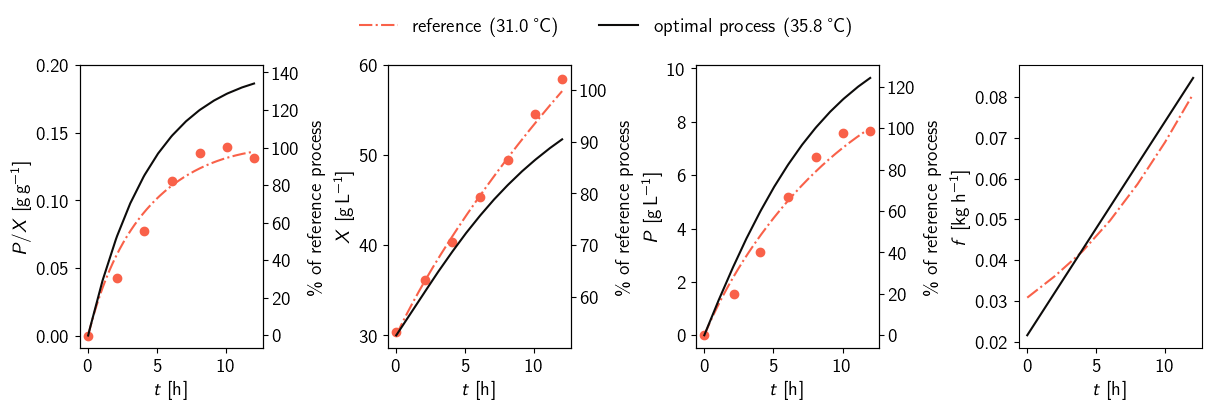

In [25]:
plot_opt_sampling(
    [
        # add_sampling(df_ref),
        df,
        # add_sampling(df_T_opt),
        opt_T_opt,
    ],
    [
        r"reference (\qty{31.0}{\celsius})",
        r"optimal process (\qty{35.8}{\celsius})",
        # r"optimal process, simplified feed (\qty{35.8}{\celsius})",
        # "P1",
        # "P2",
        # "P3",
    ],
    filename=f"{fig_path}optima_short_row.png",
    styles=["-.", "-", "--"],
    colors=color_scheme.processes[[0, 4]],
    single_row=True
    # colors=[color_scheme.processes[0], color_scheme.opt_longer_processes[0], color_scheme.processes[4]],
)

In [26]:
df_T_opt[df_T_opt.index <= 6.5].P.iloc[-1] / df_T_opt[df_T_opt.index <= 6.5].X.iloc[-1]

0.15227670371832042

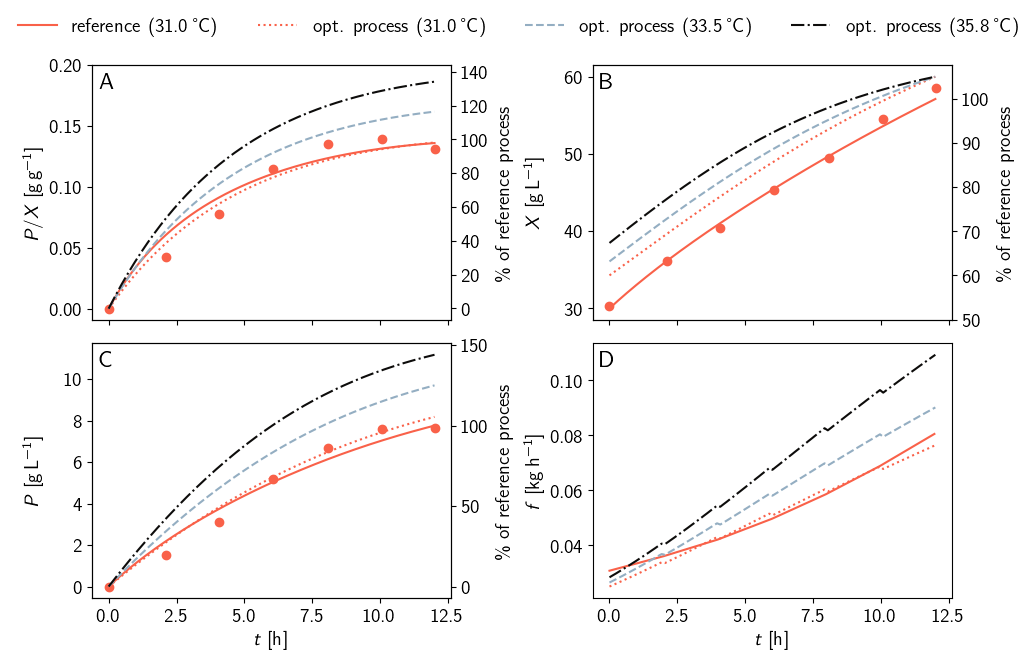

In [27]:
plot_opt_sampling(
    [
        df,
        add_sampling(df_T_31_P_X0),
        add_sampling(df_T_335_P_X0),
        add_sampling(df_T_opt_P_X0),      
    ],
    [
        r"reference (\qty{31.0}{\celsius})",
        r"opt. process (\qty{31.0}{\celsius})",
        r"opt. process (\qty{33.5}{\celsius})",
        r"opt. process (\qty{35.8}{\celsius})",
        # r"optimal process, simplified feed (\qty{35.8}{\celsius})",
        # "P1",
        # "P2",
        # "P3",
    ],
    filename=f"{fig_path}optima_short_P.png",
    styles=["-", ":", "--", "-."],
    colors=color_scheme.processes[[0, 0, 3, 4]],
    # colors=[color_scheme.processes[0], color_scheme.opt_longer_processes[0], color_scheme.processes[4]],
)

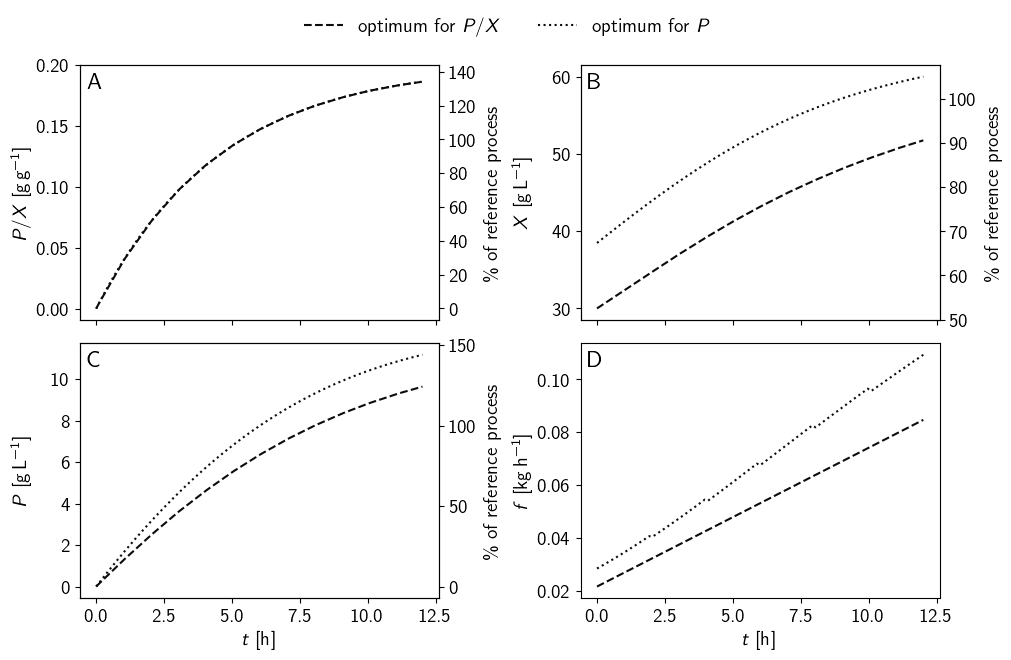

In [28]:
plot_opt_sampling(
    [
        # df,
        opt_T_opt,
        add_sampling(df_T_opt_P_X0),      
    ],
    [
        # r"reference (\qty{31.0}{\celsius})",
        r"optimum for $P/X$",
        r"optimum for $P$",
        # r"optimal process, simplified feed (\qty{35.8}{\celsius})",
        # "P1",
        # "P2",
        # "P3",
    ],
    filename=f"{fig_path}optima_PX_P.png",
    styles=["--", ":", "--", "-."],
    colors=color_scheme.processes[[4, 4]],
    # colors=[color_scheme.processes[0], color_scheme.opt_longer_processes[0], color_scheme.processes[4]],
    data_df_opt=None
)

In [29]:
df_T_opt_P_X0.P.values[-1] / opt_T_opt.f(opt_T_opt.opt.x)[1][1][-1]

1.1593089165602133

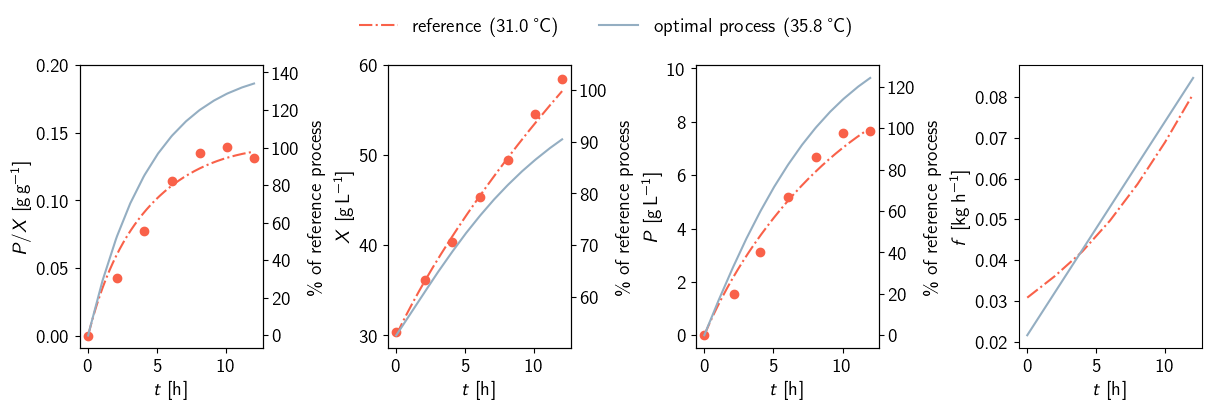

In [30]:
plot_opt_sampling(
    [
        # add_sampling(df_ref),
        df,
        # add_sampling(df_T_opt),
        opt_T_opt,        
    ],
    [
        r"reference (\qty{31.0}{\celsius})",
        r"optimal process (\qty{35.8}{\celsius})",
        # r"optimal process, simplified feed (\qty{35.8}{\celsius})",
        # "P1",
        # "P2",
        # "P3",
    ],
    # filename=f"{fig_path}optima_short.png",
    styles=["-.", "-", "--"],
    colors=color_scheme.processes[[0, 3, 4]],
    single_row=True
    # colors=[color_scheme.processes[0], color_scheme.opt_longer_processes[0], color_scheme.processes[4]],
)

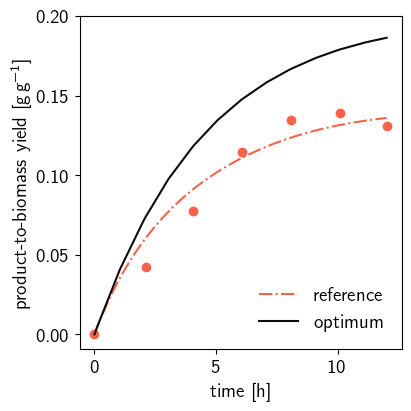

In [31]:
data_df_opt = data_df[data_df.process == "DoE2_R4"]


def plot_opt_sampling_1_plot(
    optima: list,
    labels: list[str],
    styles=["-", "--", "-.", ":", ":"],
    colors=["b", "orange", "g", "r", "m"],
    filename=None,
    legend_rows=1,
    return_fig=False,
):
    fig, ax_PX = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")

    for opt, label, style, color in zip(optima, labels, styles, colors):
        if isinstance(opt, pd.DataFrame):
            df = opt
            # c_f = df.c_feed
            T = df["T"]
        else:
            t, x, V0 = opt.f(opt.opt.x)
            # c_f = opt.c_feed
            fis = opt.opt.x[:-1]
            f = [opt.get_f(ti, fis) for ti in t]
            T = opt.opt.x[-1]
            df = pd.DataFrame(x.T, columns=["X", "P", "V"], index=t)
            X0 = df.X.iloc[0]
            df["f"] = f
            df["n"] = np.log2(df.X * df.V / (X0 * V0))

        ax_PX.plot(df.P / df.X, linestyle=style, color=color, label=label)

    ax_PX.scatter(data_df_opt.t, data_df_opt.P / data_df_opt.X, color=colors[0])
    ax_PX.set_ylabel(r"product-to-biomass yield [\si{\gram\per\gram}]")

    # ax_PX_T = ax_PX.twinx()
    # mn, mx = ax_PX.get_ylim()
    # ax_PX_T.set_ylim(
    #     mn * 100 / (P_max_ref / X_max_ref), mx * 100 / (P_max_ref / X_max_ref)
    # )
    # ax_PX_T.set_ylabel(r"\unit{\percent} of reference process")

    # ax_PX_T.set_yticks(np.linspace(0, 140, 8))

    legend = ax_PX.legend(
        loc="lower right",
        # bbox_to_anchor=(0.5, 1),
        # ncol=5,
        frameon=False,
    )

    ax_PX.set_yticks(np.linspace(0, 0.2, 5))

    ax_PX.set_xlabel(r"time [\unit{\hour}]")

    if filename is not None:
        fig.savefig(filename, bbox_inches="tight")

    plt.show()

df = add_sampling(df_ref).copy()

for i in range(len(df.index)):
    if i not in [len(df.index) // 6 * i for i in range(7)]:
        df.iloc[i, 4] = np.nan

plot_opt_sampling_1_plot(
    [
        # add_sampling(df_ref),
        df,
        # add_sampling(df_T_opt),
        opt_T_opt,
    ],
    [
        r"reference",
        # r"optimal process (\qty{35.8}{\celsius})",
        r"optimum",
        # "P1",
        # "P2",
        # "P3",
    ],
    filename=f"{fig_path}optima_PX.png",
    styles=["-.", "-", "--"],
    colors=color_scheme.processes[[0, 4]],
    # colors=[color_scheme.processes[0], color_scheme.opt_longer_processes[0], color_scheme.processes[4]],
)

In [32]:
29 // 4

7

In [33]:
data_df_opt

,t,X,P,G,T,t_process,V,f_cum,f_base_cum,process
21,0.000000,30.366667,0.00,0.0,304.187,24.491667,0.935842,0.058470,0.063226,DoE2_R4
22,2.116667,36.133333,1.53,0.0,304.236,26.608333,0.995786,0.108484,0.072319,DoE2_R4
23,4.058333,40.366667,3.13,0.0,304.208,28.550000,1.006582,0.164409,0.081132,DoE2_R4
24,6.066667,45.300000,5.19,0.0,304.214,30.558333,1.032307,0.233908,0.091445,DoE2_R4
25,8.091667,49.466667,6.67,0.0,304.275,32.583333,1.073738,0.318548,0.102188,DoE2_R4
26,10.066667,54.566667,7.59,0.0,304.216,34.558333,1.131730,0.417837,0.114939,DoE2_R4
27,12.016667,58.466667,7.67,0.0,303.960,36.508333,1.208208,0.536103,0.127079,DoE2_R4


In [34]:
df_ref

,X,P,V,c_feed,f,n,T,g,gm,gP,qP,g_mu,mu
0.000000,30.000000,0.000000,1.300000,360.86998,0.030768,0.000000,304.15,0.284699,0.067235,0.087189,0.056847,0.130276,0.138530
0.012012,30.039075,0.014822,1.300459,360.86998,0.030794,0.002388,304.15,0.284611,0.067524,0.086935,0.056654,0.130152,0.138219
0.024024,30.078088,0.029608,1.300919,360.86998,0.030821,0.004770,304.15,0.284524,0.067811,0.086683,0.056462,0.130030,0.137910
0.036036,30.117039,0.044358,1.301379,360.86998,0.030847,0.007147,304.15,0.284437,0.068096,0.086433,0.056271,0.129908,0.137604
0.048048,30.155927,0.059073,1.301839,360.86998,0.030873,0.009519,304.15,0.284352,0.068380,0.086185,0.056082,0.129787,0.137299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.951952,57.022469,7.747619,2.066549,360.86998,0.090403,1.595280,304.15,0.320380,0.171559,0.031110,0.017528,0.117711,0.081304
11.963964,57.043671,7.751646,2.067794,360.86998,0.090497,1.596685,304.15,0.320407,0.171588,0.031095,0.017519,0.117724,0.081301
11.975976,57.064863,7.755667,2.069042,360.86998,0.090591,1.598091,304.15,0.320434,0.171617,0.031081,0.017510,0.117737,0.081298
11.987988,57.086048,7.759683,2.070290,360.86998,0.090685,1.599497,304.15,0.320461,0.171645,0.031066,0.017502,0.117750,0.081295


## Summarize results

In [35]:
opt335_only_T_changes = copy.deepcopy(opt31)
opt335_only_T_changes.opt.x[-3] = 335 + 273.15

opt36_only_T_changes = copy.deepcopy(opt31)
opt36_only_T_changes.opt.x[-3] = 36 + 273.15

P_ref = df_ref.P.iloc[-1]
X_ref = df_ref.X.iloc[-1]
l = [
    [
        "reference process",
        "-",
        P_ref,
        0,
        P_ref / X_ref,
        0,
        X_ref,
        add_sampling(df_ref).V.iloc[-1] / df_ref.V.iloc[0],
    ],
    [
        "measurements",
        "-",
        data_df_opt.P.iloc[-1],
        data_df_opt.P.iloc[-1] / P_ref - 1,
        data_df_opt.P.iloc[-1] / data_df_opt.X.iloc[-1],
        data_df_opt.P.iloc[-1] / data_df_opt.X.iloc[-1] / (P_ref / X_ref) - 1,
        data_df_opt.X.iloc[-1],
        data_df_opt.V.iloc[-1] / data_df_opt.V.iloc[0],
    ],
]

for opt, process_name in zip(
    [opt31, opt335, opt_T_opt],
    [f"T = {T:,.1f} °C opt process" for T in [31, 33.5, 35.8]]
    + [f"T = {T}, feed not adapted for temperature" for T in [33.5, 35.8]],
):
    t, x, V0s = opt.f(opt.opt.x)
    P_opt = x[1][-1]
    X_end = x[0][-1]
    f0, f_end, T = opt.opt.x
    k = (f_end - f0) / t_end
    improvement = (P_opt / P_ref - 1) * 100
    P_X = P_opt / X_end
    improvement_P_X = (P_X / (P_ref / X_ref) - 1) * 100
    l.append(
        [
            process_name,
            f"f = {f0:,.5f} + {k:,.5f} t",
            P_opt,
            improvement,
            P_X,
            improvement_P_X,
            X_end,
            x[2][-1] / x[2][0],
        ]
    )
for df, name in zip(
    [df_T_31, df_T_335, df_T_opt],
    ["T = 31.0 °C, free feed", "T = 33.5 °C, free feed", "T = 35.8 °C, free feed"],
):
    l.append(
        [
            name,
            "-",
            df.P.iloc[-1],
            (df.P.iloc[-1] / P_ref - 1) * 100,
            df.P.iloc[-1] / df.X.iloc[-1],
            (df.P.iloc[-1] / df.X.iloc[-1] / (P_ref / X_ref) - 1) * 100,
            df.X.iloc[-1],
            add_sampling(df).V.iloc[-1] / df.V.iloc[0],
        ]
    )

df = pd.DataFrame(
    l,
    columns=[
        "process",
        "feed rate",
        "product concentration",
        "improvement product concentration [%]",
        "product per biomass",
        "improvement product per biomass [%]",
        "final biomass concentration",
        "V / V0",
    ],
)
s = df.style
s.format(precision=2)
# s.to_latex("table.tex", siunitx=True)

,process,feed rate,product concentration,improvement product concentration [%],product per biomass,improvement product per biomass [%],final biomass concentration,V / V0
0,reference process,-,7.76,0.00,0.14,0.00,57.11,1.42
1,measurements,-,7.67,-0.01,0.13,-0.04,58.47,1.29
2,T = 31.0 °C opt process,f = 0.02208 + 0.00377 t,7.51,-3.24,0.14,0.34,55.07,1.35
3,T = 33.5 °C opt process,f = 0.02190 + 0.00443 t,8.65,11.47,0.16,18.99,53.50,1.38
4,T = 35.8 °C opt process,f = 0.02154 + 0.00526 t,9.64,24.23,0.19,37.08,51.76,1.42
5,"T = 31.0 °C, free feed",-,7.51,-3.23,0.14,0.34,55.07,1.35
6,"T = 33.5 °C, free feed",-,8.65,11.48,0.16,18.99,53.50,1.38
7,"T = 35.8 °C, free feed",-,9.64,24.22,0.19,37.08,51.75,1.42


In [44]:
0.18625090316265255 / (P_ref / X_ref)

1.3700015245959134

In [36]:
opt_T_opt.opt

     fun: -0.18635595812001823
     jac: array([-7.50788320e-06, -1.69309011e-07,  2.22044429e-07])
 message: 'Optimization terminated successfully.'
    nfev: 1210
     nit: 25
 success: True
       x: array([2.15397000e-02, 8.46860529e-02, 3.08935631e+02])

In [37]:
class FOpt():
    def __init__(self, opt, t_end):
        self.opt = opt
        f0, f_end, T = opt.x
        self.T = T
        self.intersect = f0
        self.slope = (f_end - f0) / t_end

    def f(self, t):
        return self.slope * t + self.intersect

f_opt = FOpt(opt_T_opt.opt, t_end)

if use_AIC:
    with open(f"{data_path}f_opt_AIC", "wb") as f:
        pickle.dump(f_opt, f)
        
else:
    with open(f"{data_path}f_opt.pickle", "wb") as f:
        pickle.dump(f_opt, f)

In [38]:
def plot_rates(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = [matplotlib.colors.to_rgba(x, alpha=0.4) for x in color_scheme.general]
    ax.fill_between(
        df.index,
        df.gP + df.g_mu,
        df.gP + df.g_mu + df.gm,
        label="$\gm$",
        facecolor=colors[2],
        edgecolor="k",
        aa=True,
    )

    ax.fill_between(
        df.index,
        df.gP,
        df.gP + df.g_mu,
        label="$\gmu$",
        facecolor=colors[1],
        edgecolor="k",
        aa=True,
    )

    ax.fill_between(
        df.index,
        0,
        df.gP,
        label="$\gP$",
        facecolor=colors[0],
        edgecolor="k",
        aa=True,
    )

    ax.set_xlabel("t [h]")
    ax.set_ylabel("rate [1/h]")
    ax.legend(loc="upper left", frameon=False)

In [39]:
df = df_T_opt
df["n"] = np.log2(df.X * df.V / (X0 * V0))

df["f_X"] = df.f * c_feed / (df.X * df.V)
df["g"] = df.f / df.V * c_feed / (df.X - df.P) 
df["gm"] = f_gm(df.g, 0, df.n, df.P, df.X, T)
df["gP"] = f_gP(df.g, df.gm, 0, df.n, df.P, df.X, T)
df["qP"] = df.gP * Y_PG * (1 - df.P / df.X)
df["g_mu"] = df.g - df.gm - df.gP

# df["gm"] = df.gm * (1 - df.P / df.X)
# df["gP"] = df.gP * (1 - df.P / df.X)
# df["g_mu"] = df.g_mu * (1 - df.P / df.X)

df = df[df.f.notna()]

with open(f"{data_path}opt_rates", "wb") as f:
    pickle.dump(df, f)

In [40]:
df

,X,P,V,f,T,n,f_X,g,gm,gP,qP,g_mu
0.00,30.000000,0.000000,1.300000,0.022100,308.935628,0.000000,0.204491,0.204491,0.048300,0.067591,0.044069,0.088600
0.12,30.282843,0.158114,1.303337,0.022682,308.935628,0.017237,0.207388,0.208476,0.051639,0.067025,0.043472,0.089813
0.24,30.565768,0.314929,1.306746,0.023195,308.935628,0.034421,0.209568,0.211750,0.054821,0.066286,0.042773,0.090643
0.36,30.848681,0.470437,1.310226,0.023787,308.935628,0.051551,0.212381,0.215670,0.058186,0.065722,0.042197,0.091763
0.48,31.131559,0.624660,1.313780,0.024322,308.935628,0.068628,0.214600,0.218994,0.061406,0.065023,0.041545,0.092565
...,...,...,...,...,...,...,...,...,...,...,...,...
11.52,51.231256,9.469539,2.032549,0.092445,308.935628,1.416840,0.320374,0.393019,0.252843,0.031474,0.016728,0.108703
11.64,51.363705,9.514454,2.044944,0.093212,308.935628,1.429337,0.320245,0.393054,0.253209,0.031277,0.016615,0.108567
11.76,51.494579,9.558554,2.057435,0.093921,308.935628,1.441793,0.319908,0.392825,0.253396,0.031068,0.016496,0.108361
11.88,51.623906,9.601852,2.070021,0.094690,308.935628,1.454211,0.319764,0.392828,0.253721,0.030877,0.016388,0.108230


In [41]:
df.iloc[-1,:] / df.iloc[0,:]

X       1.725057
P            inf
V       1.602079
f       4.316133
T       1.000000
n            inf
f_X     1.561736
g       1.919439
gm      5.255258
gP      0.453757
qP      0.369195
g_mu    1.219078
dtype: float64